# Imports

In [90]:
import os
from datetime import datetime
import pytz

import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from time import strftime

from keras.datasets import cifar10
from IPython.display import display
from tensorflow.keras.utils import array_to_img as ati
from keras.callbacks import TensorBoard

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [2]:
os.environ['kmp_duplicate_lib_ok']='true'

In [3]:
from numpy.random import seed
seed(888)
tf.random.set_seed(404)

# Constants

In [82]:
LOG_DIR  = 'tensorboard_cifar_logs/'

LABEL_NAMES = [
'Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_PIXELS = IMG_HEIGHT*IMG_WIDTH
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMG_PIXELS*COLOR_CHANNELS

NR_CLASSES=10
VALIDATION_SIZE = 10000
TRAIN_SIZE = 40000
SMALL_TRAIN_SIZE = 1000

# Get the data

In [5]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [6]:
nr_images, x, y, c = x_train_all.shape

# Explore the data

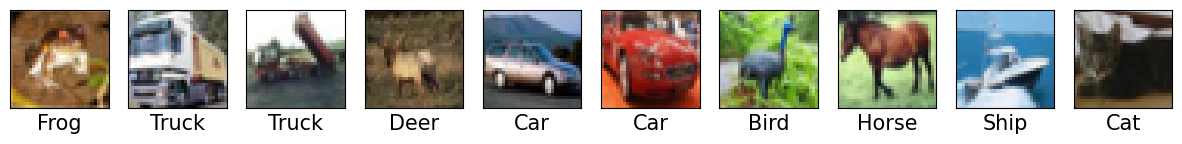

In [7]:
plt.figure(figsize=(15,5))
for a in range(10):
    plt.subplot(1, 10, a+1)
    plt.imshow(x_train_all[a])
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[a][0]], fontsize=15)
plt.show()

# Preprocess Data

In [8]:
x_train_all, x_test = x_train_all/255.0, x_test/255.0

In [9]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

In [10]:
x_train_all[0]

array([0.23137255, 0.24313725, 0.24705882, ..., 0.48235294, 0.36078431,
       0.28235294])

In [11]:
x_test = x_test.reshape(x_test.shape[0], TOTAL_INPUTS)

# Create Validation Dataset

In [12]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [13]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

## Create a small dataset


In [14]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras

In [15]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='ml_hidden1'),
    Dense(units=64, activation='relu', name='ml_hidden2'),
    Dense(16, activation='relu', name='ml_hidden3'),
    Dense(10, activation='softmax', name='output')
])

model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [24]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [27]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m3_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(16, activation='relu', name='m3_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m3_output'))

model_3.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [16]:
type(model_1)

keras.engine.sequential.Sequential

In [28]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 3072)              0         
                                                                 
 m3_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 m3_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m3_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m3_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-tr

# Tensorboard (Visualising learning)

In [18]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')

    return TensorBoard(log_dir=dir_paths)

In [19]:
print( f' Model 1 at {strftime("%H %M")}')

 Model 1 at 21 20


# Fit the model

In [29]:
samples_per_batch = 1000

In [30]:
%%time
nr_epochs = 100
model_1.fit(x=x_train, y=y_train,
            batch_size=samples_per_batch,
            epochs=nr_epochs,verbose=0,
            callbacks=[get_tensorboard('Model 1 XL')],
            validation_data=(x_val,y_val))

Successfully created directory
CPU times: total: 1min 1s
Wall time: 1min 51s


In [31]:
%%time
nr_epochs = 100
model_2.fit(x=x_train, y=y_train,
            batch_size=samples_per_batch,
            epochs=nr_epochs,verbose=0,
            callbacks=[get_tensorboard('Model 2 XL')],
            validation_data=(x_val,y_val))

Successfully created directory
CPU times: total: 3min 27s
Wall time: 3min 16s


In [32]:
%%time
nr_epochs = 100
model_3.fit(x=x_train, y=y_train,
            batch_size=samples_per_batch,
            epochs=nr_epochs,verbose=0,
            callbacks=[get_tensorboard('Model 3 XL')],
            validation_data=(x_val,y_val))

Successfully created directory
CPU times: total: 4min 6s
Wall time: 3min 28s


# Predictions on Individual Images

In [33]:
x_val.shape

(10000, 3072)

In [41]:
test = np.expand_dims(x_val[0], axis=0)
test.shape

(1, 3072)

In [42]:
np.set_printoptions(precision = 3)

In [43]:
model_2.predict(test)

1/1 [==============================] - 0s 34ms/step


D:\Anaconda\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([[0.094, 0.02 , 0.125, 0.168, 0.147, 0.123, 0.277, 0.035, 0.007,
        0.005]], dtype=float32)

In [54]:
np.argmax(model_2.predict(test), axis=-1)[0]

1/1 [==============================] - 0s 23ms/step


6

In [69]:
y_val[0]
sum=0

In [70]:
for number in range(10):
    test_img = np.expand_dims(x_val[number], axis=0)
    predicted_val = np.argmax(model_2.predict(test_img), axis=-1)[0]
    #print(f'Actual value:{y_val[number][0]} vs. predicted: {predicted_val}')
    if y_val[number][0]==predicted_val:
        sum=sum+1
print(sum/10)

1/1 [==============================] - 0s 18ms/step
0.4


In [62]:
x_val.shape

(10000, 3072)

# Evaluation

In [65]:
model_2.metrics_names

['loss', 'accuracy']

In [67]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

  7/313 [..............................] - ETA: 2s - loss: 1.4344 - accuracy: 0.4866 

D:\Anaconda\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 2s 8ms/step - loss: 1.4425 - accuracy: 0.4906
Test loss is 1.44 and test accuracy is 49.1%


# Confusion Matrix

In [72]:
predictions = np.argmax(model_2.predict(x_test), axis=-1)
conf_matrix = confusion_matrix(y_true = y_test, y_pred=predictions)

313/313 [==============================] - 1s 2ms/step


In [74]:
conf_matrix.shape
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

In [75]:
conf_matrix.max()

724

In [76]:
conf_matrix.min()

2

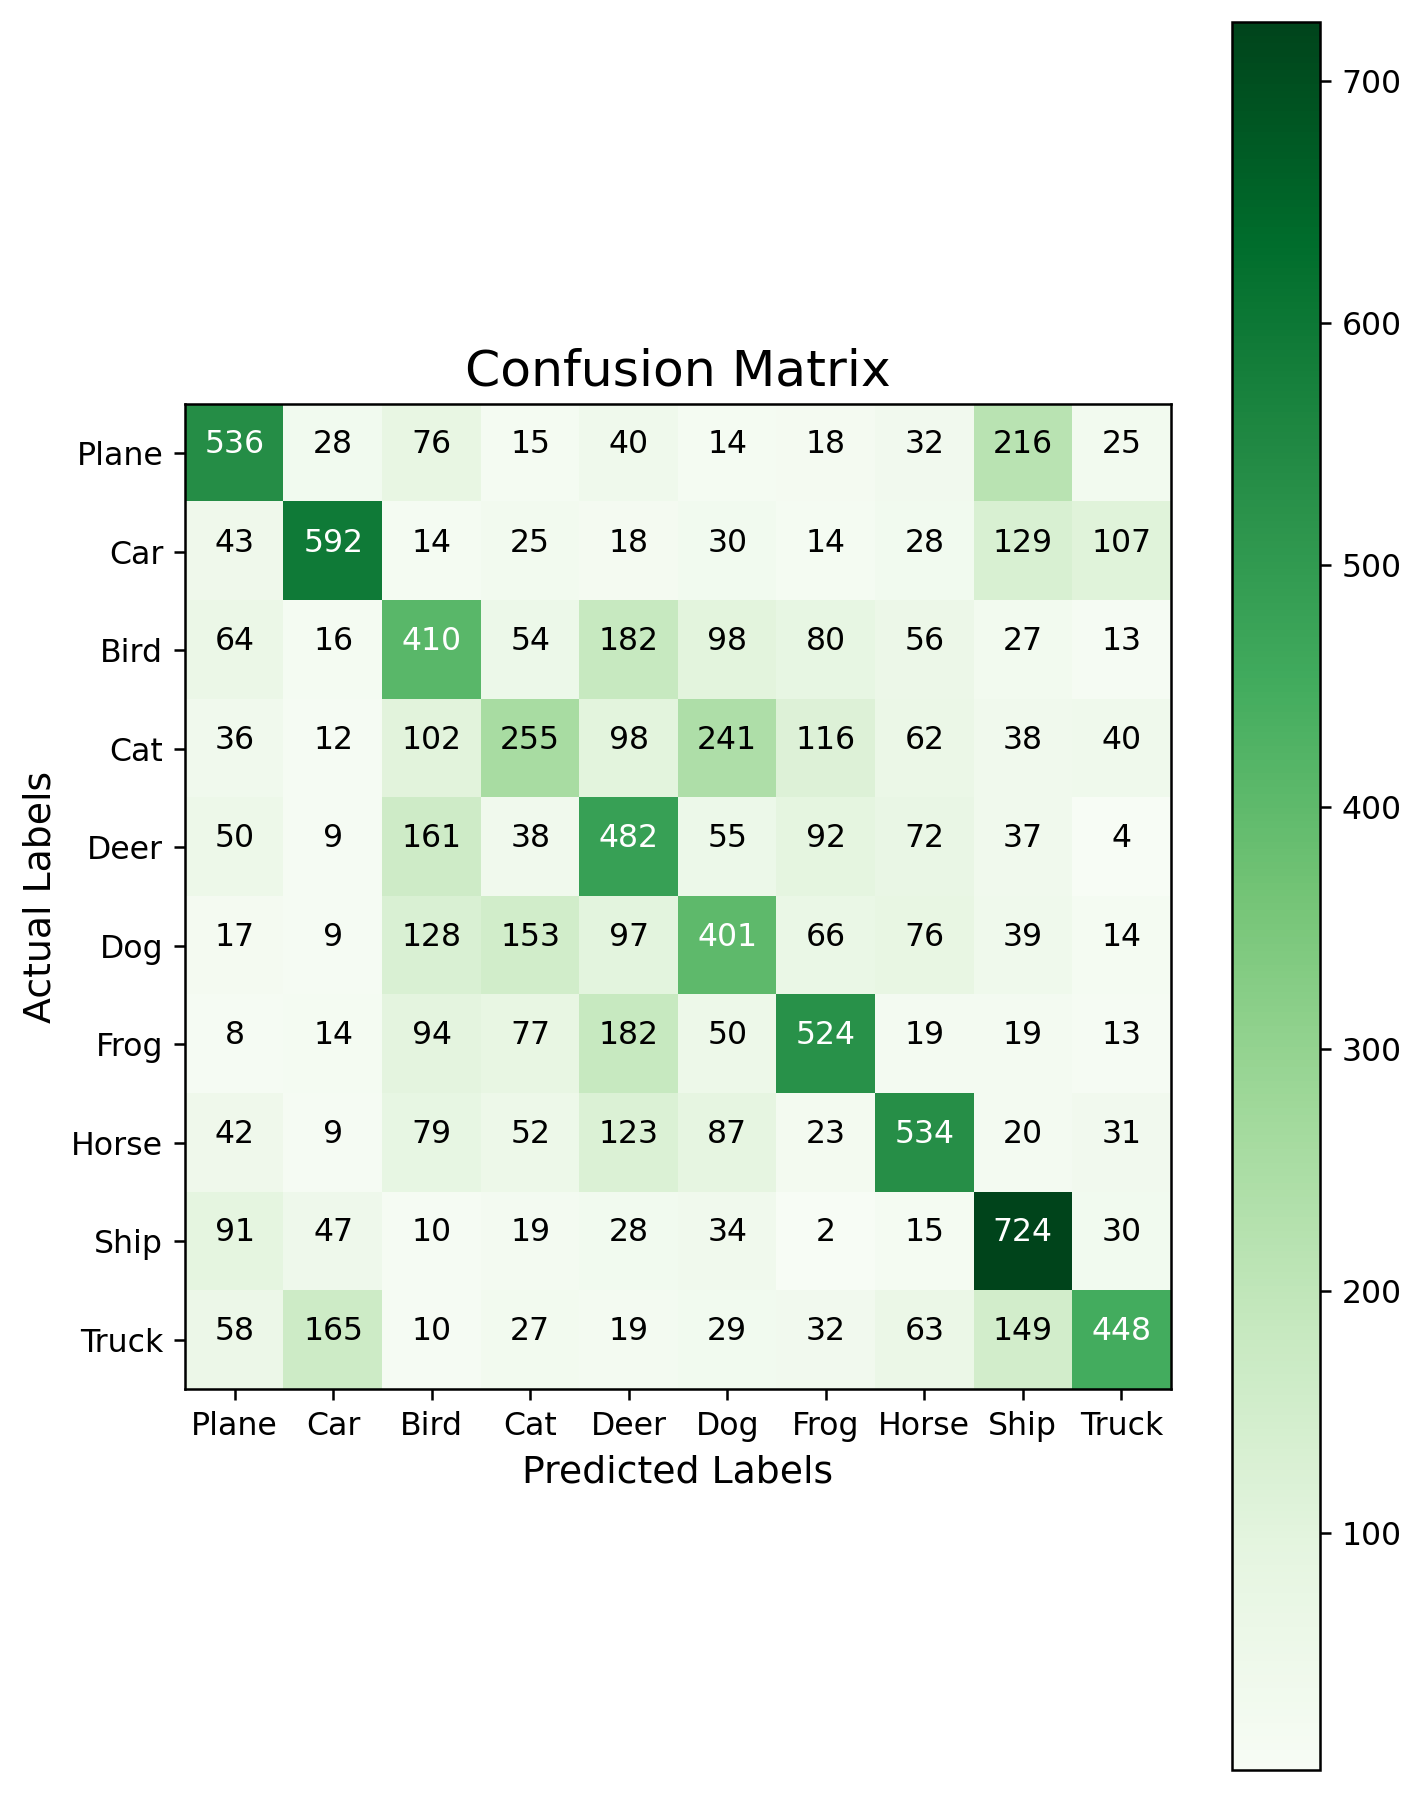

In [97]:
plt.figure(figsize=(7,10), dpi=227)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)
plt.colorbar()

for i,j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i,j], horizontalalignment='center',
             color = 'white' if conf_matrix[i,j] > conf_matrix.max()/2 else 'black' )
plt.show()


In [98]:
# True Positives: Values along the Diagonal
# False Positives: Values down the column
# True Negatives:
# False Negatives: Values across the row

In [99]:
np.diag(conf_matrix).sum()

4906

In [101]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall
# recall = (TP)/(TP+FP)

array([0.536, 0.592, 0.41 , 0.255, 0.482, 0.401, 0.524, 0.534, 0.724,
       0.448])

In [103]:
precision=np.diag(conf_matrix)/np.sum(conf_matrix, axis=0)
precision
# precision = (TP)/(TP+FP)

array([0.567, 0.657, 0.378, 0.357, 0.38 , 0.386, 0.542, 0.558, 0.518,
       0.618])

In [106]:
avg_recall=np.mean(recall)

In [107]:
avg_prec=np.mean(precision)

In [108]:
f1_score = 2*(avg_prec*avg_recall)/(avg_prec+avg_recall)

In [109]:
f1_score

0.4933138966338823